# Homework 3

In [4]:
# use Julia's packae managing module to activate your current environment
using Pkg
Pkg.activate(".")

  Activating project at `~/vision/Assignment 3`


- Topic: contour completion via long-range interactions
- Again, model LGN as center-surround and V1 as oriented filters
- In addition, include long-range lateral connections for contour completion in V1

In [5]:
# telling Julia to load modules that we need for our code, which have been specified as dependencies for our current package
using Images
using FileIO
using Plots
default(xticks=false, yticks=false, color=:grays, titlefontsize=8)

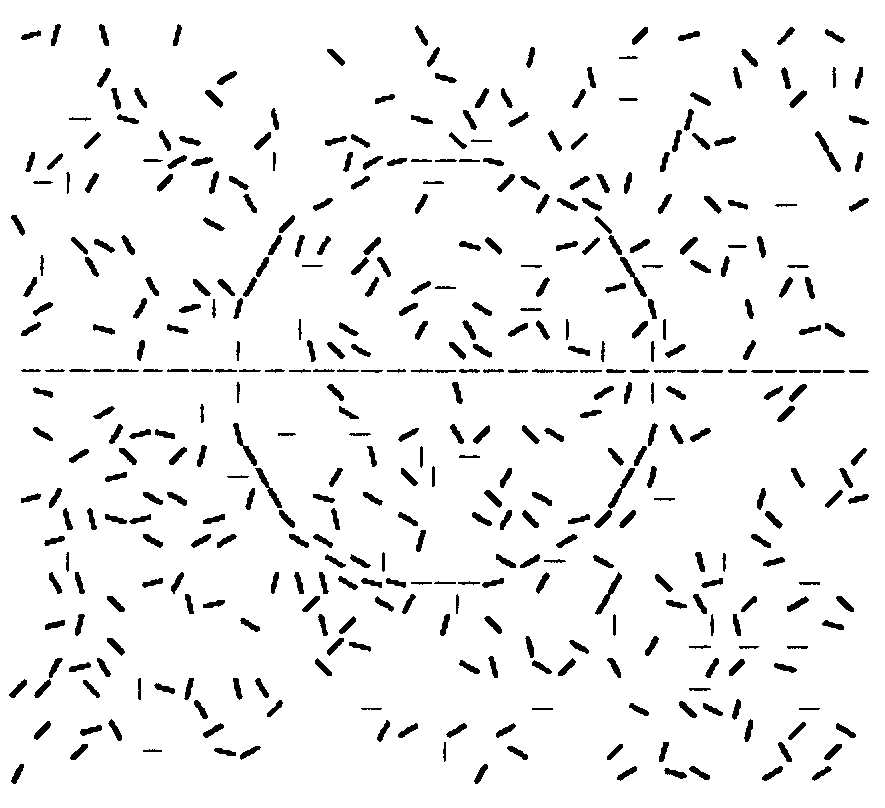

In [6]:
# load the additional Utils module provided with the exercise and the stimulus
include("material/utils.jl")
using .Utils: getgabor

# Image from Fig.5 in L. Zhaoping. “A Neural Model of Contour Integration in the Primary Visual Cortex.” In: Neural Computation, 10(4) (1998), pp. 903–40.
img = float.(load("material/LiCircleStim.png"))

- We will use the channel-dimension to represent different orientations etc.
- Therefore, it's more conventient to work with raw `Array`s instead of grayscale images

In [7]:
img = channelview(img);

## Task 1: Formation of V1 Activity

### LGN Response

- We model LGN as a DoG filter with $\sigma_C=0.7$ and $\sigma_S = 2$

In [8]:
# ...to be implemented: 
dog_filter = Utils.customDoG(0.7, 2, 1)


9×9 OffsetArray(::Matrix{Float64}, -4:4, -4:4) with eltype Float64 with indices -4:4×-4:4:
 -0.000763447  -0.00183141  -0.00342153  …  -0.00183141  -0.000763447
 -0.00183141   -0.00439333  -0.00820727     -0.00439333  -0.00183141
 -0.00342153   -0.00820727  -0.0152417      -0.00820727  -0.00342153
 -0.00497829   -0.0119303   -0.0203355      -0.0119303   -0.00497829
 -0.00564113   -0.0134991   -0.0198006      -0.0134991   -0.00564113
 -0.00497829   -0.0119303   -0.0203355   …  -0.0119303   -0.00497829
 -0.00342153   -0.00820727  -0.0152417      -0.00820727  -0.00342153
 -0.00183141   -0.00439333  -0.00820727     -0.00439333  -0.00183141
 -0.000763447  -0.00183141  -0.00342153     -0.00183141  -0.000763447

### Gabor Filters

- We model V1 as Gabor filters applied to the LGN output.
- We use the `getgabor` function loaded above to do this

In [9]:
# ...to be implemented: 
f₀ = 0.1
σ = 5.0
orientations = 0:15:165
gabor_filters = [getgabor(f₀, σ, θ) for θ in orientations]

12-element Vector{OffsetArrays.OffsetMatrix{ComplexF64, Matrix{ComplexF64}}}:
 [0.004634441287258743 + 1.1274642485455702e-18im 0.006762439937986209 + 1.6486735957862257e-18im … 0.006762439937986209 + 1.6486735957862257e-18im 0.004634441287258743 + 1.1274642485455702e-18im; 0.005476891162465216 + 0.003956512302656763im 0.00799434140787142 + 0.005785546968081903im … 0.00799434140787142 + 0.005785546968081903im 0.005476891162465216 + 0.003956512302656763im; … ; 0.005476891162465216 - 0.003956512302656763im 0.00799434140787142 - 0.005785546968081903im … 0.00799434140787142 - 0.005785546968081903im 0.005476891162465216 - 0.003956512302656763im; 0.004634441287258743 - 1.1274642485455702e-18im 0.006762439937986209 - 1.6486735957862257e-18im … 0.006762439937986209 - 1.6486735957862257e-18im 0.004634441287258743 - 1.1274642485455702e-18im]
 [0.0009283636324650371 - 0.004545388643141091im 0.0023267173711286077 - 0.006386747783345624im … -0.0005171252494323695 + 0.006692807106278571im -0.0010246

### V1 Response

- We generate 12 orientation for V1 (spaced with 15 degree differences)
- Each is implemented as a Gabor filter
- Applying the Gabor filter requires a bit of care, since Gabor filters are complex
    - filtering via the Fourier transform can be problematic
    - either specify `Algorithm.FIR()` or filter real and imaginary part separately

In [10]:
# ...to be implemented: 
function process_image(img, dog_kernel, gabor_filters)
    img = Utils.normalize(img)
    lgn_response = imfilter(img, dog_kernel, Algorithm.FIR())
    
    h, w = size(img)
    act_v1 = Array{Float64}(undef, h, w, length(gabor_filters))
    
    for (i, gabor) in enumerate(gabor_filters)
        gabor_real = real(gabor)
        gabor_imag = imag(gabor)
        
        response_real = imfilter(lgn_response, gabor_real, Algorithm.FIR())
        response_imag = imfilter(lgn_response, gabor_imag, Algorithm.FIR())
        
        act_v1[:, :, i] = abs.(response_real + im * response_imag)
    end
    
    return act_v1
end

act_v1 = process_image(img, dog_filter, gabor_filters)

808×885×12 Array{Float64, 3}:
[:, :, 1] =
 3.34196e-31  3.34196e-31  3.34196e-31  …  3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31  …  3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 ⋮                                      ⋱               
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31  …  3.34196e-31  3.34196e-31
 3.34196e-31  3.34196e-31  3.34196e-31     3.34196e-31  3.34196e-31
 3.34196e-31  3.3

## Task 2: Long-Range Interaction

### Filter components

- Each long-range filter has two components:
    - radial component determines the distance at which contrasts interact
    - angular component determines how much relative poitions may deviate from optimal alignment
- Missing in our example: relatabiliy (how much may orientations vary); we use delta function

In [11]:
# ...to be implemented: 

### Generating long-range filters

- To create long-range filter, we generate a mask (sampled in x and y)
- Need to convert (x,y) coordinates into $r$ and $\varphi$ for radial and angular component

In [30]:
# ...to be implemented: 
#using LinearAlgebra

function longrangefilter(theta, sigma, rmax, kappa)
    theta = deg2rad(theta)  # Convert angle to radians
    s = 2 * rmax + 4 * sigma + 1  # Size of the filter mask
    center = (rmax + 2 * sigma + 1, rmax + 2 * sigma + 1)  # Center of the filter mask
    filter_mask = zeros(Float64, s, s)  # Initialize the filter mask with zeros
    
    for x in 1:s
        for y in 1:s
            dx = x - center[1]
            dy = y - center[2]
            r = hypot(dx, dy)
            φ = atan(dy, dx)
            
            if r <= rmax
                Brad = 1
            else
                Brad = exp(-((r - rmax)^2) / (2 * sigma^2))
            end
            
            Bang = exp(kappa * cos(φ - theta))
            
            filter_mask[x, y] = Bang * Brad
        end
    end
    
    filter_mask = Utils.normalize(filter_mask)
    
    return filter_mask
end

function generate_filter_banks(orientations, sigma, rmax, kappa)
    right_filters = []
    left_filters = []
    
    for theta in orientations
        right_filter = longrangefilter(theta, sigma, rmax, kappa)
        left_filter = longrangefilter(theta + 180, sigma, rmax, kappa)
        
        push!(right_filters, right_filter)
        push!(left_filters, left_filter)
    end
    
    return right_filters, left_filters
end





generate_filter_banks (generic function with 1 method)

## Applying the filters

- Each filter is convolved with V1 map of corresponding orientation

In [33]:
# ...to be implemented: 
orientations = 0:15:165
sigma = 5
rmax = 60
kappa = 50

right_filters, left_filters = generate_filter_banks(orientations, sigma, rmax, kappa)

img = Float64.(load("material/LiCircleStim.png"))
img_norm = Utils.normalize(img)
function apply_filters(img, filters)
    responses = []
    for filter in filters
        response = imfilter(img, filter, Algorithm.FIR())
        push!(responses, response)
    end
    return responses
end

all_filters = vcat(right_filters, left_filters)
responses = apply_filters(img, all_filters)



- To visualize results, we select maximum orientation at each location
- Locations with weak response (< 0.3 max) are suppressed

### Common plot of results

In [14]:
# ...to be implemented: 


process_responses (generic function with 1 method)

In [15]:
# savefig("responses.pdf")